# 0. Environment & Reproducibility

이 노트북은 Chest X-ray 이미지를 이용해 **폐렴(PNEUMONIA) 여부를 분류**하는 모델을 학습합니다.

- Pretrained backbone: **ResNet50**
- Input size: **224 × 224**
- Evaluation focus: **Recall(폐렴 미탐지 최소화) + F1-score(균형 확인)**

재현 가능한 실험을 위해:
- Seed 고정
- Device(GPU/CPU) 확인
- 실험 결과 저장 경로를 통일합니다.

In [1]:
# [Code Cell] 0-1. Imports

import os
import random
from pathlib import Path
from datetime import datetime

import numpy as np
import torch

In [2]:
# [Code Cell] 0-2. Seed 고정 함수

def set_seed(seed: int = 42, deterministic: bool = False):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    if deterministic:
        # 재현성 ↑ (대신 속도 ↓ 가능)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    else:
        # 속도 ↑ (약간의 비결정성 가능)
        torch.backends.cudnn.deterministic = False
        torch.backends.cudnn.benchmark = True

SEED = 42
set_seed(SEED, deterministic=False)
print("SEED =", SEED)

SEED = 42


In [3]:
# [Code Cell] 0-3. Device 확인

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))
    print("CUDA:", torch.version.cuda)
    print("cuDNN:", torch.backends.cudnn.version())

device: cuda
GPU: NVIDIA GeForce RTX 3080
CUDA: 12.6
cuDNN: 91002


In [4]:
# [Code Cell] 0-4. 프로젝트 경로/실험 저장 폴더

# 프로젝트 루트 (노트북 위치 기준)
ROOT_DIR = Path(".").resolve()

# 데이터 폴더 (예: ./content/chest_xray/ 아래에 train/val/test가 있도록 두는 걸 추천)
DATA_DIR = ROOT_DIR / "content" / "chest_xray"   # 필요시 수정
print("DATA_DIR:", DATA_DIR)

# 실행 결과 저장 폴더
RUNS_DIR = ROOT_DIR / "content" / "runs"
RUNS_DIR.mkdir(parents=True, exist_ok=True)

EXP_NAME = f"mission6_resnet50_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
EXP_DIR = RUNS_DIR / EXP_NAME
EXP_DIR.mkdir(parents=True, exist_ok=True)

print("EXP_DIR:", EXP_DIR)

DATA_DIR: C:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\chest_xray
EXP_DIR: C:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\runs\mission6_resnet50_20260116_161455


In [26]:
# [Code Cell] 0-5. 실험 설정(Config) 정리

CFG = {
    "seed": SEED,
    "img_size": 224,
    "batch_size": 32,
    "num_workers": 4,   # Windows면 0이 안정적 (Colab/Linux면 2~4 가능)
    "epochs": 10,       # 실험 단계에서는 5~10으로 시작 -> 최종 15~30 조정
    "lr_frozen": 1e-3,
    "lr_partial": 3e-4,
    "lr_full": 1e-5,
    "weight_decay": 1e-4,
    "backbone": "resnet50",
    "positive_class": "PNEUMONIA",
    "metrics_focus": ["recall", "f1"],  # 핵심 지표
}

for k, v in CFG.items():
    print(f"{k}: {v}")


seed: 42
img_size: 224
batch_size: 32
num_workers: 4
epochs: 10
lr_frozen: 0.001
lr_partial: 0.0003
lr_full: 1e-05
weight_decay: 0.0001
backbone: resnet50
positive_class: PNEUMONIA
metrics_focus: ['recall', 'f1']


In [6]:
# [Code Cell] 0-6. 버전 기록(제출용)

print("torch:", torch.__version__)

torch: 2.9.1+cu126


# 1. Mission Definition / Metrics / Label Policy

## 1) 미션 정의
흉부 X-Ray 이미지를 입력으로 받아 폐렴(PNEUMONIA) 여부를 예측하는 **이진 분류(binary classification)** 문제입니다.

- Class 0: NORMAL
- Class 1: PNEUMONIA (Positive class)

## 2) 핵심 평가 기준(의료 진단 관점)
가장 피해야 하는 상황은 **폐렴 환자를 정상으로 판단(False Negative)** 하는 것입니다.
따라서 본 실험에서는 **PNEUMONIA(양성) Recall을 핵심 지표**로 두고,
Recall만 과도하게 높여 Precision이 급격히 떨어지지 않도록 **F1-score도 함께 확인**합니다.

## 3) 라벨/평가 정책
- Label policy: `NORMAL=0`, `PNEUMONIA=1` (PNEUMONIA를 positive로 정의)
- Data usage:
  - `train`: 학습
  - `val`: 모델 선택/튜닝(검증)
  - `test`: 최종 성능 보고(마지막에 1회 평가)
- 기본 threshold: 0.5 (필요 시 val 기준으로 threshold 조정 가능)

In [7]:
# [Code Cell] 1-1. Label mapping & basic policy variables

# Label policy
CLASS_TO_IDX = {"NORMAL": 0, "PNEUMONIA": 1}
IDX_TO_CLASS = {v: k for k, v in CLASS_TO_IDX.items()}
POS_LABEL = CLASS_TO_IDX["PNEUMONIA"]  # positive class = 1

# Decision threshold (default)
THRESHOLD = 0.5

print("CLASS_TO_IDX:", CLASS_TO_IDX)
print("POS_LABEL:", POS_LABEL, "(PNEUMONIA)")
print("THRESHOLD:", THRESHOLD)

CLASS_TO_IDX: {'NORMAL': 0, 'PNEUMONIA': 1}
POS_LABEL: 1 (PNEUMONIA)
THRESHOLD: 0.5


In [8]:
# [Code Cell] 1-2. Confusion matrix & metrics (numpy 기반)

def confusion_matrix_binary(y_true, y_pred, pos_label=1):
    """
    y_true, y_pred: 1D array-like (0/1)
    returns: (tn, fp, fn, tp)
    """
    y_true = np.asarray(y_true).astype(int)
    y_pred = np.asarray(y_pred).astype(int)

    tp = np.sum((y_true == pos_label) & (y_pred == pos_label))
    tn = np.sum((y_true != pos_label) & (y_pred != pos_label))
    fp = np.sum((y_true != pos_label) & (y_pred == pos_label))
    fn = np.sum((y_true == pos_label) & (y_pred != pos_label))
    return int(tn), int(fp), int(fn), int(tp)


def safe_div(a, b, eps=1e-12):
    return a / (b + eps)


def classification_metrics_binary(y_true, y_pred, pos_label=1):
    """
    returns dict: accuracy, precision, recall, f1, tn, fp, fn, tp
    """
    tn, fp, fn, tp = confusion_matrix_binary(y_true, y_pred, pos_label=pos_label)

    accuracy  = safe_div(tp + tn, tp + tn + fp + fn)
    precision = safe_div(tp, tp + fp)
    recall    = safe_div(tp, tp + fn)  # 핵심 지표 (FN 최소화)
    f1        = safe_div(2 * precision * recall, precision + recall)

    return {
        "accuracy": float(accuracy),
        "precision": float(precision),
        "recall": float(recall),
        "f1": float(f1),
        "tn": tn, "fp": fp, "fn": fn, "tp": tp,
    }

In [9]:
# [Code Cell] 1-3. Logits → prob → pred 변환 + 배치 누적 평가용 헬퍼

@torch.no_grad()
def logits_to_pred(logits: torch.Tensor, threshold: float = 0.5):
    """
    logits: (B,) or (B,1)
    returns: prob (B,), pred (B,) int(0/1)
    """
    if logits.ndim == 2 and logits.size(1) == 1:
        logits = logits.squeeze(1)

    prob = torch.sigmoid(logits)              # (B,)
    pred = (prob >= threshold).long()         # (B,)
    return prob, pred


class MetricsAccumulator:
    """
    epoch 단위로 y_true/y_pred를 누적해서 최종 지표 계산
    """
    def __init__(self, pos_label=1):
        self.pos_label = pos_label
        self.y_true = []
        self.y_pred = []

    def update(self, y_true_batch, y_pred_batch):
        # torch -> cpu -> numpy/int
        if isinstance(y_true_batch, torch.Tensor):
            y_true_batch = y_true_batch.detach().cpu().numpy()
        if isinstance(y_pred_batch, torch.Tensor):
            y_pred_batch = y_pred_batch.detach().cpu().numpy()

        self.y_true.append(y_true_batch.astype(int))
        self.y_pred.append(y_pred_batch.astype(int))

    def compute(self):
        y_true = np.concatenate(self.y_true) if self.y_true else np.array([], dtype=int)
        y_pred = np.concatenate(self.y_pred) if self.y_pred else np.array([], dtype=int)
        return classification_metrics_binary(y_true, y_pred, pos_label=self.pos_label)

    def reset(self):
        self.y_true = []
        self.y_pred = []

In [10]:
# [Code Cell] 1-4. (선택) threshold 튜닝 정책(설명용 + 나중에 사용)

def pick_threshold_by_best_recall_f1(y_true, prob, min_recall=None):
    """
    val set에서 threshold 후보를 훑어보며:
    - (선택) recall >= min_recall 만족하는 범위에서
    - f1이 가장 높은 threshold를 고르는 정책 예시
    """
    y_true = np.asarray(y_true).astype(int)
    prob = np.asarray(prob).astype(float)

    best = {"threshold": 0.5, "f1": -1, "recall": -1, "precision": -1}
    for th in np.linspace(0.1, 0.9, 81):
        y_pred = (prob >= th).astype(int)
        m = classification_metrics_binary(y_true, y_pred, pos_label=POS_LABEL)

        if min_recall is not None and m["recall"] < min_recall:
            continue

        if m["f1"] > best["f1"]:
            best = {"threshold": float(th), "f1": m["f1"], "recall": m["recall"], "precision": m["precision"]}

    return best

print("Ready: metrics functions + accumulator + (optional) threshold policy")

Ready: metrics functions + accumulator + (optional) threshold policy


# 2. Data Load & EDA (Before DataLoader)

이 섹션에서는 DataLoader를 만들기 전에 다음을 점검합니다.

1) 데이터 폴더 구조(train/val/test) 및 클래스 폴더 확인  
2) 이미지 파일 리스트를 만들고 라벨을 부여 (NORMAL=0, PNEUMONIA=1)  
3) 클래스 분포(불균형) 확인 및 간단 EDA  
4) (선택) 제공 val이 너무 작으면, train에서 stratified split로 새 valid를 생성하여 실험 안정화  

In [11]:
# [Code Cell] 2-1. 경로/폴더 구조 점검

from pathlib import Path

TRAIN_DIR = DATA_DIR / "train"
VAL_DIR   = DATA_DIR / "val"
TEST_DIR  = DATA_DIR / "test"

print("TRAIN_DIR:", TRAIN_DIR)
print("VAL_DIR  :", VAL_DIR)
print("TEST_DIR :", TEST_DIR)

for d in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    if not d.exists():
        raise FileNotFoundError(f"Directory not found: {d}  (DATA_DIR 경로를 확인하세요)")

# 클래스 폴더 확인
expected_classes = set(CLASS_TO_IDX.keys())  # {"NORMAL","PNEUMONIA"}
print("Expected classes:", expected_classes)

def list_class_dirs(split_dir: Path):
    return sorted([p.name for p in split_dir.iterdir() if p.is_dir()])

print("Train classes:", list_class_dirs(TRAIN_DIR))
print("Val classes  :", list_class_dirs(VAL_DIR))
print("Test classes :", list_class_dirs(TEST_DIR))

TRAIN_DIR: C:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\chest_xray\train
VAL_DIR  : C:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\chest_xray\val
TEST_DIR : C:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\chest_xray\test
Expected classes: {'NORMAL', 'PNEUMONIA'}
Train classes: ['NORMAL', 'PNEUMONIA']
Val classes  : ['NORMAL', 'PNEUMONIA']
Test classes : ['NORMAL', 'PNEUMONIA']


In [12]:
# [Code Cell] 2-2. 이미지 파일 수집(경로+라벨 리스트 생성)

IMG_EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}

def collect_image_paths(split_dir: Path, class_to_idx: dict):
    """
    return: list of (img_path, label_int)
    """
    items = []
    for cls_name, y in class_to_idx.items():
        cls_dir = split_dir / cls_name
        if not cls_dir.exists():
            # 혹시 대소문자나 폴더명이 다를 때 대비
            raise FileNotFoundError(f"Class folder missing: {cls_dir}")

        for p in cls_dir.rglob("*"):
            if p.is_file() and p.suffix.lower() in IMG_EXTS:
                items.append((p, int(y)))
    return sorted(items, key=lambda x: x[0].name)

train_items = collect_image_paths(TRAIN_DIR, CLASS_TO_IDX)
val_items   = collect_image_paths(VAL_DIR, CLASS_TO_IDX)
test_items  = collect_image_paths(TEST_DIR, CLASS_TO_IDX)

print("num train:", len(train_items))
print("num val  :", len(val_items))
print("num test :", len(test_items))

print("sample train item:", train_items[0])

num train: 5216
num val  : 16
num test : 624
sample train item: (WindowsPath('C:/Users/amy/Desktop/sprint/sprint-ai07/미션/content/chest_xray/train/NORMAL/IM-0115-0001.jpeg'), 0)


In [13]:
# [Code Cell] 2-3. 클래스 분포(불균형) 확인

import numpy as np

def count_by_class(items):
    ys = np.array([y for _, y in items], dtype=int)
    counts = {IDX_TO_CLASS[c]: int(np.sum(ys == c)) for c in sorted(set(CLASS_TO_IDX.values()))}
    return counts

train_counts = count_by_class(train_items)
val_counts   = count_by_class(val_items)
test_counts  = count_by_class(test_items)

print("Train counts:", train_counts)
print("Val counts  :", val_counts)
print("Test counts :", test_counts)

def imbalance_ratio(counts_dict):
    # PNEUMONIA / NORMAL 비율(참고)
    n_norm = counts_dict.get("NORMAL", 0)
    n_pneu = counts_dict.get("PNEUMONIA", 0)
    if n_norm == 0: 
        return float("inf")
    return n_pneu / n_norm

print("Train PNEUMONIA/NORMAL ratio:", f"{imbalance_ratio(train_counts):.3f}")
print("Val   PNEUMONIA/NORMAL ratio:", f"{imbalance_ratio(val_counts):.3f}")

Train counts: {'NORMAL': 1341, 'PNEUMONIA': 3875}
Val counts  : {'NORMAL': 8, 'PNEUMONIA': 8}
Test counts : {'NORMAL': 234, 'PNEUMONIA': 390}
Train PNEUMONIA/NORMAL ratio: 2.890
Val   PNEUMONIA/NORMAL ratio: 1.000


In [14]:
# [Code Cell] 2-4. 샘플 이미지 기본 속성 확인(크기/모드) — 일부만 빠르게

from PIL import Image
from collections import Counter

def inspect_samples(items, n=200, seed=42):
    rng = np.random.default_rng(seed)
    sample = items if len(items) <= n else list(rng.choice(items, size=n, replace=False))
    modes = Counter()
    sizes = Counter()
    for p, _ in sample:
        with Image.open(p) as img:
            modes[img.mode] += 1
            sizes[img.size] += 1  # (W,H)
    return modes, sizes

modes_tr, sizes_tr = inspect_samples(train_items, n=200, seed=SEED)
print("Train sample modes:", dict(modes_tr))
print("Train sample size top5:", sizes_tr.most_common(5))

Train sample modes: {'L': 188, 'RGB': 12}
Train sample size top5: [((1472, 1048), 2), ((976, 608), 2), ((1368, 1044), 1), ((2000, 1896), 1), ((1248, 856), 1)]


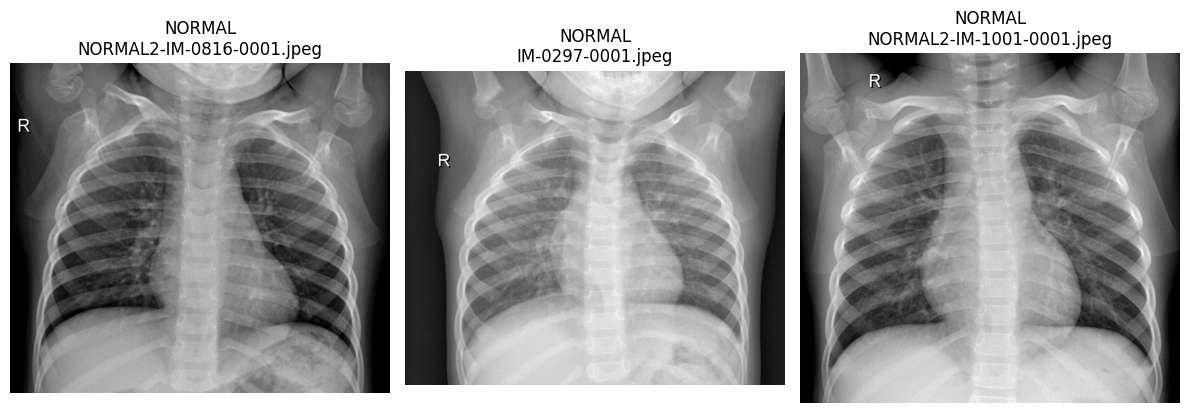

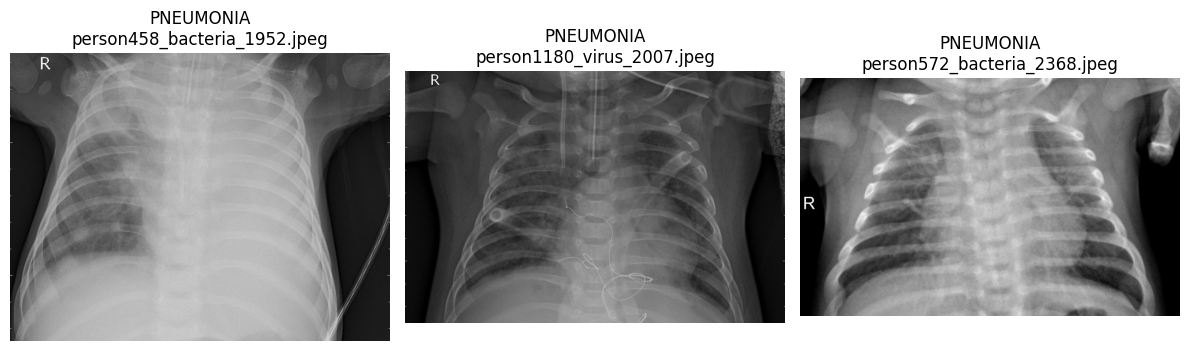

In [15]:
# [Code Cell] 2-5. 샘플 시각화(클래스별 몇 장)

import matplotlib.pyplot as plt

def show_samples_by_class(items, class_name: str, k=3, seed=42):
    y = CLASS_TO_IDX[class_name]
    paths = [p for p, yy in items if yy == y]
    rng = np.random.default_rng(seed)
    pick = paths if len(paths) <= k else list(rng.choice(paths, size=k, replace=False))

    plt.figure(figsize=(12, 4))
    for i, p in enumerate(pick):
        with Image.open(p) as img:
            img = img.convert("L")
            plt.subplot(1, k, i+1)
            plt.imshow(img, cmap="gray")
            plt.title(f"{class_name}\n{p.name}")
            plt.axis("off")
    plt.tight_layout()
    plt.show()

show_samples_by_class(train_items, "NORMAL", k=3, seed=SEED)
show_samples_by_class(train_items, "PNEUMONIA", k=3, seed=SEED)

## 2-6. If val is too small, create a new stratified valid split from train

제공된 `val` 폴더의 샘플 수가 너무 적으면 valid 지표가 크게 흔들릴 수 있습니다.  
이 경우, `train` 내부에서 클래스 비율을 유지(stratified)하며 새 valid를 생성해 실험 안정성을 높일 수 있습니다.

- 기본 정책: `val_items`가 충분하면 그대로 사용  
- `val`이 너무 작다면: `train_items`에서 일부를 떼어 `new_val_items` 구성

In [16]:
# [Code Cell] 2-7. val 크기 기준으로 split 정책 결정 + (필요시) 새 valid 생성

def stratified_split(items, val_ratio=0.1, seed=42):
    rng = np.random.default_rng(seed)
    items = np.array(items, dtype=object)

    y = np.array([yy for _, yy in items], dtype=int)

    train_idx = []
    val_idx = []

    for cls in sorted(set(y)):
        cls_idx = np.where(y == cls)[0]
        rng.shuffle(cls_idx)
        n_val = max(1, int(len(cls_idx) * val_ratio))
        val_idx.extend(cls_idx[:n_val].tolist())
        train_idx.extend(cls_idx[n_val:].tolist())

    # 섞기
    rng.shuffle(train_idx)
    rng.shuffle(val_idx)

    train_items_new = items[train_idx].tolist()
    val_items_new = items[val_idx].tolist()
    return train_items_new, val_items_new

# 정책 파라미터 (필요 시 조정)
MIN_VAL_SIZE = 200   # val이 이보다 작으면 새 valid 생성 고려
VAL_RATIO_FROM_TRAIN = 0.1

use_provided_val = len(val_items) >= MIN_VAL_SIZE
print("Provided val size:", len(val_items), "| use_provided_val =", use_provided_val)

if use_provided_val:
    train_items_final = train_items
    val_items_final = val_items
    split_note = "Use provided val/ (train 그대로)"
else:
    train_items_final, val_items_final = stratified_split(train_items, val_ratio=VAL_RATIO_FROM_TRAIN, seed=SEED)
    split_note = f"Create new valid from train (ratio={VAL_RATIO_FROM_TRAIN}) due to small provided val"

print("Split policy:", split_note)
print("Final train:", len(train_items_final))
print("Final val  :", len(val_items_final))
print("Test       :", len(test_items))

print("Final train counts:", count_by_class(train_items_final))
print("Final val counts  :", count_by_class(val_items_final))

Provided val size: 16 | use_provided_val = False
Split policy: Create new valid from train (ratio=0.1) due to small provided val
Final train: 4695
Final val  : 521
Test       : 624
Final train counts: {'NORMAL': 1207, 'PNEUMONIA': 3488}
Final val counts  : {'NORMAL': 134, 'PNEUMONIA': 387}


In [17]:
# [Code Cell] 2-8. (선택) split 리스트 저장(재현성)

import json

SPLIT_DIR = EXP_DIR / "splits"
SPLIT_DIR.mkdir(parents=True, exist_ok=True)

def save_items(items, path: Path):
    payload = [{"path": str(p), "label": int(y)} for p, y in items]
    with open(path, "w", encoding="utf-8") as f:
        json.dump(payload, f, ensure_ascii=False, indent=2)

save_items(train_items_final, SPLIT_DIR / "train_items.json")
save_items(val_items_final, SPLIT_DIR / "val_items.json")
save_items(test_items, SPLIT_DIR / "test_items.json")

with open(SPLIT_DIR / "split_note.txt", "w", encoding="utf-8") as f:
    f.write(split_note)

print("Saved splits to:", SPLIT_DIR)

Saved splits to: C:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\runs\mission6_resnet50_20260116_161455\splits


# 3. Transforms / Dataset / DataLoader

이 섹션에서는 다음을 준비합니다.

1) 입력을 **224×224**로 통일하고, ResNet50에 맞게 전처리/정규화합니다.  
2) train에는 증강(Aug0/Aug1)을 적용하고, val/test는 평가 안정성을 위해 최소 전처리만 적용합니다.  
3) (path, label) 리스트를 받아 동작하는 Dataset을 만들고 DataLoader를 생성합니다.

- Train: Augmentation 적용
- Val/Test: Resize + CenterCrop + Normalize (No augmentation)


In [18]:
# [Code Cell] 3-1. Imports (torchvision transforms)

from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

In [19]:
# [Code Cell] 3-2. ImageNet normalization (ResNet50용)

# ImageNet normalization (ResNet50 pretrained 기준)
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

IMG_SIZE = CFG["img_size"]  # 224
print("IMG_SIZE:", IMG_SIZE)

IMG_SIZE: 224


In [20]:
# [Code Cell] 3-3. Transform 정의 (Aug0 / Aug1 / Val/Test)

# 공통: PIL -> RGB 통일 함수 (흑백(L)도 3채널로 맞춤)
def to_rgb(img: Image.Image) -> Image.Image:
    return img.convert("RGB")

# Val/Test: 평가 안정용 (증강 없음)
tfm_eval = T.Compose([
    T.Lambda(to_rgb),
    T.Resize(256),           # 짧은 변을 256 근처로
    T.CenterCrop(IMG_SIZE),  # 중앙 crop으로 안정적 평가
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# Train Aug0: 기본 증강(약함)
tfm_train_aug0 = T.Compose([
    T.Lambda(to_rgb),
    T.RandomResizedCrop(
        IMG_SIZE,
        scale=(0.9, 1.0),     # 약한 확대/축소
        ratio=(0.9, 1.1)      # 가로세로 비율 약간 허용
    ),
    T.RandomAffine(
        degrees=7,              # 작은 회전
        translate=(0.05, 0.05), # 약한 이동
        scale=(0.95, 1.05)      # 약한 확대/축소(추가)
    ),
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# Train Aug1: 픽셀 기반 변환(ColorJitter) 포함 (너가 원한 밝기/대비 + 색상(hue/saturation))
# X-ray는 원래 그레이 계열이므로 saturation/hue는 아주 약하게만 적용
tfm_train_aug1 = T.Compose([
    T.Lambda(to_rgb),
    T.RandomResizedCrop(
        IMG_SIZE,
        scale=(0.85, 1.0),
        ratio=(0.85, 1.15)
    ),
    T.RandomAffine(
        degrees=10,
        translate=(0.08, 0.08),
        scale=(0.9, 1.1)
    ),
    T.ColorJitter(
        brightness=0.15,
        contrast=0.15,
        saturation=0.08,
        hue=0.02
    ),
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

print("Transforms ready: train_aug0 / train_aug1 / eval")


Transforms ready: train_aug0 / train_aug1 / eval


In [21]:
# [Code Cell] 3-4. Dataset 정의 (items 리스트 기반)

class ChestXrayDataset(Dataset):
    """
    items: list of (path: Path, label: int)
    transform: torchvision transform
    return: image tensor, label tensor, path(str)
    """
    def __init__(self, items, transform=None):
        self.items = items
        self.transform = transform

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        path, label = self.items[idx]
        img = Image.open(path)  # mode could be 'L' or 'RGB'
        # PIL Image는 lazy load가 아니라 파일 핸들 이슈가 생길 수 있어 convert 전 close를 위해 context 쓰기도 함
        # 하지만 여기서는 단순하게 처리. 문제가 있으면 with Image.open(...)로 바꾸면 됨.

        if self.transform is not None:
            img = self.transform(img)
        else:
            # transform이 없을 경우를 대비 (보통 안 씀)
            img = T.ToTensor()(img.convert("RGB"))

        y = torch.tensor(label, dtype=torch.long)
        return {"image": img, "label": y, "path": str(path)}

In [22]:
# [Code Cell] 3-5. 어떤 증강을 쓸지 선택(Aug0 기본)

# 이번 실험은 픽셀 기반 변환(ColorJitter 포함)을 보고 싶으니 Aug1 선택
TRAIN_AUG_NAME = "aug1"  # "aug0" or "aug1"

if TRAIN_AUG_NAME == "aug0":
    train_transform = tfm_train_aug0
elif TRAIN_AUG_NAME == "aug1":
    train_transform = tfm_train_aug1
else:
    raise ValueError("TRAIN_AUG_NAME must be 'aug0' or 'aug1'")

print("TRAIN_AUG_NAME:", TRAIN_AUG_NAME)

TRAIN_AUG_NAME: aug1


In [23]:
# [Code Cell] 3-6. Dataset 생성

train_ds = ChestXrayDataset(train_items_final, transform=train_transform)
val_ds   = ChestXrayDataset(val_items_final, transform=tfm_eval)
test_ds  = ChestXrayDataset(test_items, transform=tfm_eval)

print("len(train_ds):", len(train_ds))
print("len(val_ds)  :", len(val_ds))
print("len(test_ds) :", len(test_ds))

len(train_ds): 4695
len(val_ds)  : 521
len(test_ds) : 624


In [24]:
# [Code Cell] 3-7. DataLoader 생성

BATCH_SIZE = CFG["batch_size"]
NUM_WORKERS = CFG["num_workers"]

pin_memory = (device.type == "cuda")

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=pin_memory,
    drop_last=False
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=pin_memory,
    drop_last=False
)

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=pin_memory,
    drop_last=False
)

print("train batches:", len(train_loader))
print("val batches  :", len(val_loader))
print("test batches :", len(test_loader))

train batches: 147
val batches  : 17
test batches : 20


In [25]:
# [Code Cell] 3-8. Loader sanity check (shape / dtype / label)

batch = next(iter(train_loader))
x = batch["image"]
y = batch["label"]
p = batch["path"][:3]

print("image batch:", x.shape, x.dtype)  # (B,3,224,224)
print("label batch:", y.shape, y.dtype)  # (B,)
print("label unique:", torch.unique(y))
print("paths:", p)

assert x.shape[1] == 3 and x.shape[2] == IMG_SIZE and x.shape[3] == IMG_SIZE
print("[OK] DataLoader sanity check passed.")

image batch: torch.Size([32, 3, 224, 224]) torch.float32
label batch: torch.Size([32]) torch.int64
label unique: tensor([0, 1])
paths: ['C:\\Users\\amy\\Desktop\\sprint\\sprint-ai07\\미션\\content\\chest_xray\\train\\PNEUMONIA\\person1308_virus_2252.jpeg', 'C:\\Users\\amy\\Desktop\\sprint\\sprint-ai07\\미션\\content\\chest_xray\\train\\PNEUMONIA\\person769_bacteria_2673.jpeg', 'C:\\Users\\amy\\Desktop\\sprint\\sprint-ai07\\미션\\content\\chest_xray\\train\\PNEUMONIA\\person548_bacteria_2297.jpeg']
[OK] DataLoader sanity check passed.


# 4. Custom CNN & Train/Eval Loop (Preparation)

이 섹션에서는 다음을 준비합니다.

1) **Custom CNN(Conv 블록 3개)** 모델을 정의합니다.  
2) 불균형 데이터(폐렴이 더 많음)를 고려해 loss 설정에 `pos_weight` 옵션을 제공합니다.  
3) 공통 학습/검증 루프(train_one_epoch / evaluate)를 정의합니다.
   - 출력은 로짓(logit)으로 두고, sigmoid + threshold로 예측을 생성합니다.
   - 지표는 Accuracy/Precision/Recall/F1 + Confusion Matrix(TN/FP/FN/TP)를 계산합니다.

다음 섹션(5번)에서 실제로 Custom CNN을 학습하고 성능을 기록합니다.

In [27]:
# [Code Cell] 4-1. AMP/유틸(로깅)

import torch.nn as nn
import torch.nn.functional as F
from typing import Dict

USE_AMP = (device.type == "cuda")
scaler = torch.amp.GradScaler(enabled=USE_AMP)

def get_lr(optimizer):
    return optimizer.param_groups[0]["lr"]

print("USE_AMP:", USE_AMP)

USE_AMP: True


In [28]:
# [Code Cell] 4-2. Custom CNN (Conv 블록 3개)

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, pool=True, dropout=0.0):
        super().__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        ]
        if pool:
            layers.append(nn.MaxPool2d(kernel_size=2))
        if dropout and dropout > 0:
            layers.append(nn.Dropout2d(dropout))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


class CustomCNN3(nn.Module):
    """
    3개의 Conv 블록 + 글로벌 평균풀링 + FC
    - 출력은 sigmoid 이전의 logit
    """
    def __init__(self, in_ch=3, base_ch=32, dropout=0.2):
        super().__init__()
        self.features = nn.Sequential(
            ConvBlock(in_ch, base_ch,     pool=True, dropout=0.0),   # 224 -> 112
            ConvBlock(base_ch, base_ch*2, pool=True, dropout=0.0),   # 112 -> 56
            ConvBlock(base_ch*2, base_ch*4, pool=True, dropout=dropout), # 56 -> 28
        )

        self.gap = nn.AdaptiveAvgPool2d(1)  # (B,C,1,1)
        self.classifier = nn.Sequential(
            nn.Flatten(),                   # (B,C)
            nn.Linear(base_ch*4, 1)         # (B,1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        logit = self.classifier(x).squeeze(1)  # (B,)
        return logit


# 모델 생성(준비)
custom_cnn = CustomCNN3(in_ch=3, base_ch=32, dropout=0.2).to(device)
print(custom_cnn)

CustomCNN3(
  (features): Sequential(
    (0): ConvBlock(
      (net): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): ConvBlock(
      (net): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (2): ConvBlock(
      (net): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [29]:
# [Code Cell] 4-3. Loss 설정 (불균형 고려 옵션: pos_weight)

def make_bce_loss_with_optional_pos_weight(train_items, use_pos_weight=True):
    """
    BCEWithLogitsLoss(pos_weight=neg/pos)을 옵션으로 제공
    - pos_weight > 1 이면 양성(PNEUMONIA) 놓치는 것(FN)에 더 민감해질 수 있음
    """
    if not use_pos_weight:
        return nn.BCEWithLogitsLoss()

    counts = count_by_class(train_items)
    n_neg = counts.get("NORMAL", 0)
    n_pos = counts.get("PNEUMONIA", 0)
    if n_pos == 0:
        return nn.BCEWithLogitsLoss()

    pos_weight = n_neg / max(n_pos, 1)  # (neg/pos)
    pw = torch.tensor([pos_weight], dtype=torch.float32, device=device)
    print(f"Using pos_weight = neg/pos = {pos_weight:.4f}  (NORMAL={n_neg}, PNEUMONIA={n_pos})")
    return nn.BCEWithLogitsLoss(pos_weight=pw)


# Custom CNN baseline에서는 우선 pos_weight를 True로 시작해도 좋음(Recall 관점)
criterion = make_bce_loss_with_optional_pos_weight(train_items_final, use_pos_weight=True)

Using pos_weight = neg/pos = 0.3460  (NORMAL=1207, PNEUMONIA=3488)


In [30]:
# [Code Cell] 4-4. Train / Eval 루프 정의 (지표 누적 포함)

def train_one_epoch(model, loader, optimizer, criterion, device, threshold=0.5):
    model.train()
    total_loss = 0.0
    n_batches = 0

    meter = MetricsAccumulator(pos_label=POS_LABEL)

    for batch in loader:
        x = batch["image"].to(device, non_blocking=True)
        y = batch["label"].to(device, non_blocking=True).float()  # BCE용 float

        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast('cuda', enabled=USE_AMP):
            logits = model(x)                      # (B,)
            loss = criterion(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # metrics
        prob, pred = logits_to_pred(logits, threshold=threshold)
        meter.update(y_true_batch=y.long(), y_pred_batch=pred)

        total_loss += loss.item()
        n_batches += 1

    metrics = meter.compute()
    avg_loss = total_loss / max(n_batches, 1)
    return avg_loss, metrics


@torch.no_grad()
def evaluate(model, loader, criterion, device, threshold=0.5):
    model.eval()
    total_loss = 0.0
    n_batches = 0

    meter = MetricsAccumulator(pos_label=POS_LABEL)

    for batch in loader:
        x = batch["image"].to(device, non_blocking=True)
        y = batch["label"].to(device, non_blocking=True).float()

        logits = model(x)
        loss = criterion(logits, y)

        prob, pred = logits_to_pred(logits, threshold=threshold)
        meter.update(y_true_batch=y.long(), y_pred_batch=pred)

        total_loss += loss.item()
        n_batches += 1

    metrics = meter.compute()
    avg_loss = total_loss / max(n_batches, 1)
    return avg_loss, metrics

In [31]:
# [Code Cell] 4-5. Sanity Check (forward / 1 batch)

batch = next(iter(train_loader))
x = batch["image"].to(device)
y = batch["label"].to(device).float()

custom_cnn.eval()
with torch.no_grad():
    logits = custom_cnn(x)
    loss = criterion(logits, y)
    prob, pred = logits_to_pred(logits, threshold=THRESHOLD)

print("logits shape:", logits.shape)  # (B,)
print("loss:", float(loss))
print("prob min/max:", float(prob.min()), float(prob.max()))
print("pred unique:", torch.unique(pred))
print("[OK] Custom CNN + loss + pred pipeline works.")

logits shape: torch.Size([32])
loss: 0.3518666625022888
prob min/max: 0.49018794298171997 0.5039333701133728
pred unique: tensor([0, 1], device='cuda:0')
[OK] Custom CNN + loss + pred pipeline works.


# 5. Train/Validate Custom CNN + Save Best + Log Results

이 섹션에서는 Custom CNN을 학습하고, **valid 성능(Recall 중심 + F1 확인)** 이 가장 좋았던 모델을 저장합니다.

- Best 기준(기본): **val Recall 최대**, 동률이면 **val F1 최대**
- Test 평가는 모든 모델 실험이 끝난 뒤 마지막에 1회 수행합니다.
- 결과는 `results_table`에 누적 기록합니다.

In [32]:
# [Code Cell] 5-1. 학습 설정(Custom CNN)

# --- Custom CNN training config ---
CUSTOM_CFG = {
    "model_name": "CustomCNN3",
    "epochs": 8,                 # 우선 5~10으로 빠르게 확인 -> 필요시 늘리기
    "lr": 1e-3,
    "weight_decay": 1e-4,
    "use_pos_weight": False,     # ★ 기본 False 권장 (이번 데이터 분포상)
    "threshold": THRESHOLD,
    "save_dir": EXP_DIR / "checkpoints"
}

CUSTOM_CFG["save_dir"].mkdir(parents=True, exist_ok=True)

for k, v in CUSTOM_CFG.items():
    print(f"{k}: {v}")

model_name: CustomCNN3
epochs: 8
lr: 0.001
weight_decay: 0.0001
use_pos_weight: False
threshold: 0.5
save_dir: C:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\runs\mission6_resnet50_20260116_161455\checkpoints


In [33]:
# [Code Cell] 5-2. Optimizer / Criterion / (선택) Scheduler

# Criterion 재설정 (pos_weight 정책 반영)
criterion = make_bce_loss_with_optional_pos_weight(
    train_items_final,
    use_pos_weight=CUSTOM_CFG["use_pos_weight"]
)

optimizer = torch.optim.Adam(
    custom_cnn.parameters(),
    lr=CUSTOM_CFG["lr"],
    weight_decay=CUSTOM_CFG["weight_decay"]
)

# (선택) scheduler: val loss가 좋아지지 않으면 LR 감소
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=2
)

print("optimizer lr:", get_lr(optimizer))

optimizer lr: 0.001


In [34]:
# [Code Cell] 5-3. 체크포인트/로깅 유틸

def save_checkpoint(path: Path, model, optimizer, epoch: int, best_key: float, info: dict):
    ckpt = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "best_key": best_key,
        "info": info,
        "cfg": {
            "CUSTOM_CFG": CUSTOM_CFG,
            "GLOBAL_CFG": CFG,
            "split_note": split_note
        }
    }
    torch.save(ckpt, path)

def pretty_metrics(m: dict) -> str:
    return (f"acc={m['accuracy']:.4f} | prec={m['precision']:.4f} | "
            f"recall={m['recall']:.4f} | f1={m['f1']:.4f} | "
            f"(tn,fp,fn,tp)=({m['tn']},{m['fp']},{m['fn']},{m['tp']})")

In [35]:
# [Code Cell] 5-4. Train loop (Recall 우선 + F1 확인) + Best 저장

history = {
    "train_loss": [],
    "val_loss": [],
    "val_recall": [],
    "val_f1": [],
    "val_precision": [],
    "val_accuracy": [],
    "lr": []
}

best_recall = -1.0
best_f1 = -1.0
best_epoch = -1
best_path = CUSTOM_CFG["save_dir"] / "best_custom_cnn.pt"

EPOCHS = CUSTOM_CFG["epochs"]
TH = CUSTOM_CFG["threshold"]

for epoch in range(1, EPOCHS + 1):
    train_loss, train_m = train_one_epoch(custom_cnn, train_loader, optimizer, criterion, device, threshold=TH)
    val_loss, val_m     = evaluate(custom_cnn, val_loader, criterion, device, threshold=TH)

    # scheduler는 val_loss 기준으로 업데이트(안정적)
    scheduler.step(val_loss)

    # 로깅
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_recall"].append(val_m["recall"])
    history["val_f1"].append(val_m["f1"])
    history["val_precision"].append(val_m["precision"])
    history["val_accuracy"].append(val_m["accuracy"])
    history["lr"].append(get_lr(optimizer))

    print(f"[Epoch {epoch:02d}/{EPOCHS}] "
          f"train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | lr={get_lr(optimizer):.2e}")
    print("  train:", pretty_metrics(train_m))
    print("  val  :", pretty_metrics(val_m))

    # --- Best 저장 기준: Recall 최대, 동률이면 F1 최대 ---
    is_best = False
    if val_m["recall"] > best_recall + 1e-12:
        is_best = True
    elif abs(val_m["recall"] - best_recall) <= 1e-12 and val_m["f1"] > best_f1 + 1e-12:
        is_best = True

    if is_best:
        best_recall = val_m["recall"]
        best_f1 = val_m["f1"]
        best_epoch = epoch

        info = {
            "train_loss": train_loss,
            "val_loss": val_loss,
            "val_metrics": val_m,
            "threshold": TH
        }
        save_checkpoint(best_path, custom_cnn, optimizer, epoch, best_key=best_recall, info=info)
        print(f"  -> Saved BEST: {best_path.name} (best_recall={best_recall:.4f}, best_f1={best_f1:.4f})")

[Epoch 01/8] train_loss=0.4070 | val_loss=0.4831 | lr=1.00e-03
  train: acc=0.8096 | prec=0.8309 | recall=0.9338 | f1=0.8793 | (tn,fp,fn,tp)=(544,663,231,3257)
  val  : acc=0.7601 | prec=0.7569 | recall=0.9974 | f1=0.8606 | (tn,fp,fn,tp)=(10,124,1,386)
  -> Saved BEST: best_custom_cnn.pt (best_recall=0.9974, best_f1=0.8606)
[Epoch 02/8] train_loss=0.3437 | val_loss=0.9549 | lr=1.00e-03
  train: acc=0.8462 | prec=0.8752 | recall=0.9249 | f1=0.8994 | (tn,fp,fn,tp)=(747,460,262,3226)
  val  : acc=0.5029 | prec=0.9923 | recall=0.3333 | f1=0.4990 | (tn,fp,fn,tp)=(133,1,258,129)
[Epoch 03/8] train_loss=0.3207 | val_loss=0.2663 | lr=1.00e-03
  train: acc=0.8550 | prec=0.8840 | recall=0.9263 | f1=0.9047 | (tn,fp,fn,tp)=(783,424,257,3231)
  val  : acc=0.9002 | prec=0.9614 | recall=0.9018 | f1=0.9307 | (tn,fp,fn,tp)=(120,14,38,349)
[Epoch 04/8] train_loss=0.2949 | val_loss=0.4442 | lr=1.00e-03
  train: acc=0.8726 | prec=0.9045 | recall=0.9263 | f1=0.9153 | (tn,fp,fn,tp)=(866,341,257,3231)
  val 

In [36]:
# [Code Cell] 5-5. Best 모델 로드 + Val 재평가(확인용)

ckpt = torch.load(best_path, map_location=device, weights_only=False)
custom_cnn.load_state_dict(ckpt["model_state"])

val_loss_best, val_m_best = evaluate(custom_cnn, val_loader, criterion, device, threshold=TH)

print("Loaded best checkpoint:", best_path.name)
print("best epoch:", ckpt["epoch"])
print("val_loss(best):", f"{val_loss_best:.4f}")
print("val_metrics(best):", pretty_metrics(val_m_best))

Loaded best checkpoint: best_custom_cnn.pt
best epoch: 1
val_loss(best): 0.4831
val_metrics(best): acc=0.7601 | prec=0.7569 | recall=0.9974 | f1=0.8606 | (tn,fp,fn,tp)=(10,124,1,386)


In [37]:
# [Code Cell] 5-6. 결과표(results_table)에 기록 (모든 실험 누적용)

import pandas as pd

# results_table이 없으면 생성
if "results_table" not in globals():
    results_table = []

row = {
    "model": CUSTOM_CFG["model_name"],
    "backbone": "custom",
    "strategy": "baseline_customcnn",
    "train_aug": TRAIN_AUG_NAME,
    "img_size": CFG["img_size"],
    "threshold": TH,
    "epochs": EPOCHS,
    "best_epoch": int(ckpt["epoch"]),
    "val_accuracy": float(val_m_best["accuracy"]),
    "val_precision": float(val_m_best["precision"]),
    "val_recall": float(val_m_best["recall"]),
    "val_f1": float(val_m_best["f1"]),
    "val_tn": int(val_m_best["tn"]),
    "val_fp": int(val_m_best["fp"]),
    "val_fn": int(val_m_best["fn"]),
    "val_tp": int(val_m_best["tp"]),
    "ckpt_path": str(best_path),
    "note": split_note
}

results_table.append(row)

df_results = pd.DataFrame(results_table)
df_results.sort_values(by=["val_recall", "val_f1"], ascending=False, inplace=True)
df_results.reset_index(drop=True, inplace=True)
df_results

,model,backbone,strategy,train_aug,img_size,threshold,epochs,best_epoch,val_accuracy,val_precision,val_recall,val_f1,val_tn,val_fp,val_fn,val_tp,ckpt_path,note
0,CustomCNN3,custom,baseline_customcnn,aug1,224,0.5,8,1,0.760077,0.756863,0.997416,0.860647,10,124,1,386,C:\Users\amy\Desktop\sprint\sprint-ai07\미션\con...,Create new valid from train (ratio=0.1) due to...


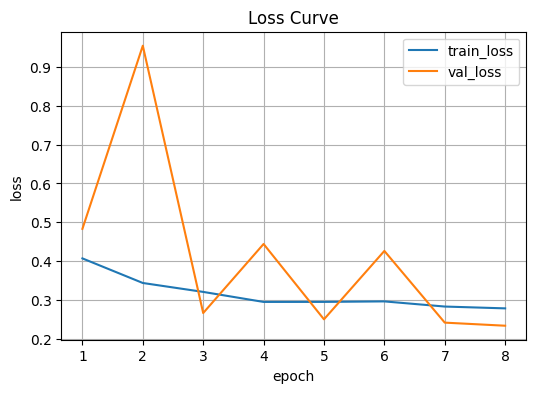

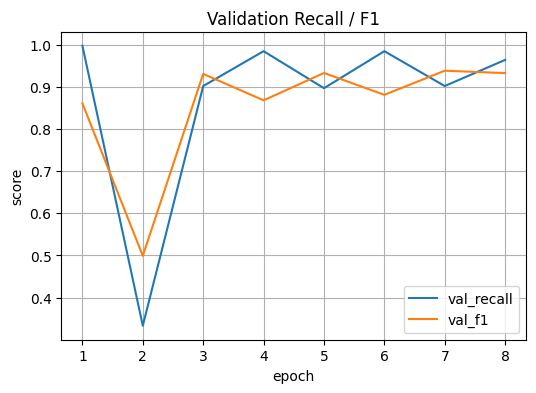

In [38]:
# [Code Cell] 5-7. (선택) 학습 곡선 Plot (Loss / Recall / F1)

import matplotlib.pyplot as plt

epochs_axis = np.arange(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs_axis, history["train_loss"], label="train_loss")
plt.plot(epochs_axis, history["val_loss"], label="val_loss")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Loss Curve")
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs_axis, history["val_recall"], label="val_recall")
plt.plot(epochs_axis, history["val_f1"], label="val_f1")
plt.xlabel("epoch"); plt.ylabel("score"); plt.title("Validation Recall / F1")
plt.legend(); plt.grid(True); plt.show()

# 6. ResNet50 Transfer Learning (Frozen)

사전 학습된 ResNet50을 사용해 **Transfer Learning (Frozen)** 실험을 수행합니다.

- Backbone(ResNet50): **freeze**
- Classifier head만 학습
- 모델 선택 기준: **val Recall 최대**, 동률이면 **val F1 최대**

In [39]:
# [Code Cell] 6-1. Imports (torchvision)

import torchvision
import torchvision.models as models
import torch.nn as nn

In [40]:
# [Code Cell] 6-2. ResNet50 Binary Classifier 래퍼

class ResNet50Binary(nn.Module):
    """
    ResNet50 backbone + binary classification head
    output: (B,) logits
    """
    def __init__(self, pretrained=True):
        super().__init__()

        # torchvision 버전에 따라 weights API가 다를 수 있어 try/except로 처리
        if pretrained:
            try:
                weights = models.ResNet50_Weights.DEFAULT
                self.backbone = models.resnet50(weights=weights)
            except Exception:
                self.backbone = models.resnet50(pretrained=True)
        else:
            self.backbone = models.resnet50(weights=None)

        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features, 1)  # (B,1)

    def forward(self, x):
        logits = self.backbone(x)           # (B,1)
        return logits.squeeze(1)            # (B,)

In [41]:
# [Code Cell] 6-3. Frozen 설정 + Trainable params 확인

def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

resnet_frozen = ResNet50Binary(pretrained=True).to(device)

# backbone freeze: fc만 학습
for name, p in resnet_frozen.named_parameters():
    p.requires_grad = False

# fc만 unfreeze
for p in resnet_frozen.backbone.fc.parameters():
    p.requires_grad = True

print(resnet_frozen)
print("Trainable params:", count_trainable_params(resnet_frozen))

ResNet50Binary(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
  

In [42]:
# [Code Cell] 6-4. 학습 설정(ResNet50 Frozen)

RESNET_FROZEN_CFG = {
    "model_name": "ResNet50",
    "strategy": "frozen",
    "epochs": 5,                # 우선 빠르게 확인 -> 필요시 10~20으로 증가
    "lr": CFG["lr_frozen"],     # 1e-3
    "weight_decay": CFG["weight_decay"],
    "use_pos_weight": False,    # 이번 데이터 분포에서는 우선 False 권장
    "threshold": THRESHOLD,
    "save_dir": EXP_DIR / "checkpoints"
}
RESNET_FROZEN_CFG["save_dir"].mkdir(parents=True, exist_ok=True)

for k, v in RESNET_FROZEN_CFG.items():
    print(f"{k}: {v}")

model_name: ResNet50
strategy: frozen
epochs: 5
lr: 0.001
weight_decay: 0.0001
use_pos_weight: False
threshold: 0.5
save_dir: C:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\runs\mission6_resnet50_20260116_161455\checkpoints


In [43]:
# [Code Cell] 6-5. Optimizer / Criterion / Scheduler

# Criterion (동일 정책)
criterion = make_bce_loss_with_optional_pos_weight(
    train_items_final,
    use_pos_weight=RESNET_FROZEN_CFG["use_pos_weight"]
)

# Frozen이므로 fc 파라미터만 optimizer에 넣기
optimizer = torch.optim.Adam(
    resnet_frozen.backbone.fc.parameters(),
    lr=RESNET_FROZEN_CFG["lr"],
    weight_decay=RESNET_FROZEN_CFG["weight_decay"]
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=2
)

print("optimizer lr:", get_lr(optimizer))

optimizer lr: 0.001


In [44]:
# [Code Cell] 6-6. 학습/검증 + Best 저장(Recall 우선, 동률이면 F1)

history_frozen = {
    "train_loss": [], "val_loss": [],
    "val_recall": [], "val_f1": [],
    "val_precision": [], "val_accuracy": [],
    "lr": []
}

best_recall = -1.0
best_f1 = -1.0
best_epoch = -1
best_path_frozen = RESNET_FROZEN_CFG["save_dir"] / "best_resnet50_frozen.pt"

EPOCHS = RESNET_FROZEN_CFG["epochs"]
TH = RESNET_FROZEN_CFG["threshold"]

for epoch in range(1, EPOCHS + 1):
    train_loss, train_m = train_one_epoch(resnet_frozen, train_loader, optimizer, criterion, device, threshold=TH)
    val_loss, val_m     = evaluate(resnet_frozen, val_loader, criterion, device, threshold=TH)

    scheduler.step(val_loss)

    history_frozen["train_loss"].append(train_loss)
    history_frozen["val_loss"].append(val_loss)
    history_frozen["val_recall"].append(val_m["recall"])
    history_frozen["val_f1"].append(val_m["f1"])
    history_frozen["val_precision"].append(val_m["precision"])
    history_frozen["val_accuracy"].append(val_m["accuracy"])
    history_frozen["lr"].append(get_lr(optimizer))

    print(f"[Frozen Epoch {epoch:02d}/{EPOCHS}] "
          f"train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | lr={get_lr(optimizer):.2e}")
    print("  train:", pretty_metrics(train_m))
    print("  val  :", pretty_metrics(val_m))

    # Best 기준: Recall 최대, 동률이면 F1 최대
    is_best = False
    if val_m["recall"] > best_recall + 1e-12:
        is_best = True
    elif abs(val_m["recall"] - best_recall) <= 1e-12 and val_m["f1"] > best_f1 + 1e-12:
        is_best = True

    if is_best:
        best_recall = val_m["recall"]
        best_f1 = val_m["f1"]
        best_epoch = epoch

        info = {
            "train_loss": train_loss,
            "val_loss": val_loss,
            "val_metrics": val_m,
            "threshold": TH
        }
        save_checkpoint(best_path_frozen, resnet_frozen, optimizer, epoch, best_key=best_recall, info=info)
        print(f"  -> Saved BEST: {best_path_frozen.name} (best_recall={best_recall:.4f}, best_f1={best_f1:.4f})")


[Frozen Epoch 01/5] train_loss=0.3628 | val_loss=0.2499 | lr=1.00e-03
  train: acc=0.8322 | prec=0.8294 | recall=0.9745 | f1=0.8961 | (tn,fp,fn,tp)=(508,699,89,3399)
  val  : acc=0.9021 | prec=0.9078 | recall=0.9664 | f1=0.9362 | (tn,fp,fn,tp)=(96,38,13,374)
  -> Saved BEST: best_resnet50_frozen.pt (best_recall=0.9664, best_f1=0.9362)
[Frozen Epoch 02/5] train_loss=0.2415 | val_loss=0.2036 | lr=1.00e-03
  train: acc=0.9131 | prec=0.9292 | recall=0.9558 | f1=0.9423 | (tn,fp,fn,tp)=(953,254,154,3334)
  val  : acc=0.9098 | prec=0.9187 | recall=0.9638 | f1=0.9407 | (tn,fp,fn,tp)=(101,33,14,373)
[Frozen Epoch 03/5] train_loss=0.2156 | val_loss=0.1925 | lr=1.00e-03
  train: acc=0.9154 | prec=0.9409 | recall=0.9455 | f1=0.9432 | (tn,fp,fn,tp)=(1000,207,190,3298)
  val  : acc=0.9098 | prec=0.9146 | recall=0.9690 | f1=0.9410 | (tn,fp,fn,tp)=(99,35,12,375)
  -> Saved BEST: best_resnet50_frozen.pt (best_recall=0.9690, best_f1=0.9410)
[Frozen Epoch 04/5] train_loss=0.2053 | val_loss=0.1744 | lr=1.

In [45]:
# [Code Cell] 6-7. Best 로드 + Val 재평가(확인)

ckpt = torch.load(best_path_frozen, map_location=device, weights_only=False)
resnet_frozen.load_state_dict(ckpt["model_state"])

val_loss_best, val_m_best = evaluate(resnet_frozen, val_loader, criterion, device, threshold=TH)

print("Loaded best checkpoint:", best_path_frozen.name)
print("best epoch:", ckpt["epoch"])
print("val_loss(best):", f"{val_loss_best:.4f}")
print("val_metrics(best):", pretty_metrics(val_m_best))


Loaded best checkpoint: best_resnet50_frozen.pt
best epoch: 3
val_loss(best): 0.1925
val_metrics(best): acc=0.9098 | prec=0.9146 | recall=0.9690 | f1=0.9410 | (tn,fp,fn,tp)=(99,35,12,375)


In [46]:
# [Code Cell] 6-8. 결과표(results_table)에 기록

import pandas as pd

if "results_table" not in globals():
    results_table = []

row = {
    "model": "ResNet50",
    "backbone": "resnet50",
    "strategy": "frozen",
    "train_aug": TRAIN_AUG_NAME,
    "img_size": CFG["img_size"],
    "threshold": TH,
    "epochs": EPOCHS,
    "best_epoch": int(ckpt["epoch"]),
    "val_accuracy": float(val_m_best["accuracy"]),
    "val_precision": float(val_m_best["precision"]),
    "val_recall": float(val_m_best["recall"]),
    "val_f1": float(val_m_best["f1"]),
    "val_tn": int(val_m_best["tn"]),
    "val_fp": int(val_m_best["fp"]),
    "val_fn": int(val_m_best["fn"]),
    "val_tp": int(val_m_best["tp"]),
    "ckpt_path": str(best_path_frozen),
    "note": split_note
}
results_table.append(row)

df_results = pd.DataFrame(results_table)
df_results.sort_values(by=["val_recall", "val_f1"], ascending=False, inplace=True)
df_results.reset_index(drop=True, inplace=True)
df_results

,model,backbone,strategy,train_aug,img_size,threshold,epochs,best_epoch,val_accuracy,val_precision,val_recall,val_f1,val_tn,val_fp,val_fn,val_tp,ckpt_path,note
0,CustomCNN3,custom,baseline_customcnn,aug1,224,0.5,8,1,0.760077,0.756863,0.997416,0.860647,10,124,1,386,C:\Users\amy\Desktop\sprint\sprint-ai07\미션\con...,Create new valid from train (ratio=0.1) due to...
1,ResNet50,resnet50,frozen,aug1,224,0.5,5,3,0.909789,0.914634,0.968992,0.941029,99,35,12,375,C:\Users\amy\Desktop\sprint\sprint-ai07\미션\con...,Create new valid from train (ratio=0.1) due to...


# 7. ResNet50 Partial Fine-Tuning (Partial FT)

이번 실험은 **ResNet50의 일부만 학습(Partial Fine-Tuning)** 하여,
Frozen 대비 성능 향상, Full FT 대비 안정성과 효율을 노립니다.

기본 전략:
- Freeze: conv1 ~ layer3 (feature extractor 대부분 고정)
- Unfreeze: layer4 + fc (상위 특징 & 분류기만 학습)

주의:
- Frozen된 블록의 BatchNorm이 train 모드로 남아 있으면 통계가 흔들릴 수 있어,
  Partial FT에서는 "frozen 블록은 eval 모드 유지"가 도움이 될 때가 많습니다.

In [47]:
# [Code Cell] 7-1. Partial FT 모델 생성 (ResNet50Binary 재사용)

resnet_partial = ResNet50Binary(pretrained=True).to(device)
print("Model created: ResNet50Binary (partial fine-tuning target)")

Model created: ResNet50Binary (partial fine-tuning target)


In [48]:
# [Code Cell] 7-2. Freeze/Unfreeze 정책 적용 (layer4 + fc만 학습)

# 1) 전체 freeze
for p in resnet_partial.parameters():
    p.requires_grad = False

# 2) layer4 + fc만 unfreeze
for p in resnet_partial.backbone.layer4.parameters():
    p.requires_grad = True
for p in resnet_partial.backbone.fc.parameters():
    p.requires_grad = True

print("Trainable params:", sum(p.numel() for p in resnet_partial.parameters() if p.requires_grad))

Trainable params: 14966785


In [49]:
# [Code Cell] 7-3. (중요) Partial FT용 train 모드 설정(BN 흔들림 방지)

def set_partial_train_mode(model, trainable_blocks=("layer4", "fc")):
    """
    - 전체는 train 모드로 두되,
    - frozen 블록(conv1~layer3)은 eval로 돌려 BN/Dropout 통계가 흔들리지 않게 함.
    """
    model.train()

    # backbone children: conv1, bn1, relu, maxpool, layer1, layer2, layer3, layer4, avgpool, fc
    for name, module in model.backbone.named_children():
        if name in trainable_blocks:
            module.train()
        else:
            module.eval()

print("Ready: set_partial_train_mode()")

Ready: set_partial_train_mode()


In [50]:
# [Code Cell] 7-4. Partial FT 전용 train_one_epoch 정의(기존 루프 재사용 형태)

def train_one_epoch_partial_ft(model, loader, optimizer, criterion, device, threshold=0.5):
    # Partial FT 모드 적용 (frozen 블록 eval 유지)
    set_partial_train_mode(model, trainable_blocks=("layer4", "fc"))

    total_loss = 0.0
    n_batches = 0
    meter = MetricsAccumulator(pos_label=POS_LABEL)

    for batch in loader:
        x = batch["image"].to(device, non_blocking=True)
        y = batch["label"].to(device, non_blocking=True).float()

        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast('cuda', enabled=USE_AMP):
            logits = model(x)
            loss = criterion(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        prob, pred = logits_to_pred(logits, threshold=threshold)
        meter.update(y_true_batch=y.long(), y_pred_batch=pred)

        total_loss += loss.item()
        n_batches += 1

    metrics = meter.compute()
    avg_loss = total_loss / max(n_batches, 1)
    return avg_loss, metrics

print("Ready: train_one_epoch_partial_ft()")

Ready: train_one_epoch_partial_ft()


In [51]:
# [Code Cell] 7-5. 학습 설정(Partial FT)

RESNET_PARTIAL_CFG = {
    "model_name": "ResNet50",
    "strategy": "partial_ft_layer4",
    "epochs": 8,                   # Frozen보다 조금 더 돌려도 좋음 (상황에 따라 10~20)
    "lr_backbone": CFG["lr_partial"],  # 3e-4
    "lr_head": CFG["lr_frozen"],       # head는 조금 더 크게(1e-3)
    "weight_decay": CFG["weight_decay"],
    "use_pos_weight": False,
    "threshold": THRESHOLD,
    "save_dir": EXP_DIR / "checkpoints"
}
RESNET_PARTIAL_CFG["save_dir"].mkdir(parents=True, exist_ok=True)

for k, v in RESNET_PARTIAL_CFG.items():
    print(f"{k}: {v}")

model_name: ResNet50
strategy: partial_ft_layer4
epochs: 8
lr_backbone: 0.0003
lr_head: 0.001
weight_decay: 0.0001
use_pos_weight: False
threshold: 0.5
save_dir: C:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\runs\mission6_resnet50_20260116_161455\checkpoints


In [52]:
# [Code Cell] 7-6. Optimizer(파라미터 그룹) / Criterion / Scheduler

criterion = make_bce_loss_with_optional_pos_weight(
    train_items_final,
    use_pos_weight=RESNET_PARTIAL_CFG["use_pos_weight"]
)

# layer4와 fc를 서로 다른 lr로 주기 (discriminative LR)
params = [
    {"params": resnet_partial.backbone.layer4.parameters(), "lr": RESNET_PARTIAL_CFG["lr_backbone"]},
    {"params": resnet_partial.backbone.fc.parameters(), "lr": RESNET_PARTIAL_CFG["lr_head"]},
]

optimizer = torch.optim.Adam(params, weight_decay=RESNET_PARTIAL_CFG["weight_decay"])

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=2
)

print("optimizer lrs:", [g["lr"] for g in optimizer.param_groups])

optimizer lrs: [0.0003, 0.001]


In [53]:
# [Code Cell] 7-7. 학습/검증 + Best 저장(Recall 우선, 동률이면 F1)

history_partial = {
    "train_loss": [], "val_loss": [],
    "val_recall": [], "val_f1": [],
    "val_precision": [], "val_accuracy": [],
    "lr_backbone": [], "lr_head": []
}

best_recall = -1.0
best_f1 = -1.0
best_epoch = -1
best_path_partial = RESNET_PARTIAL_CFG["save_dir"] / "best_resnet50_partial_ft.pt"

EPOCHS = RESNET_PARTIAL_CFG["epochs"]
TH = RESNET_PARTIAL_CFG["threshold"]

for epoch in range(1, EPOCHS + 1):
    train_loss, train_m = train_one_epoch_partial_ft(resnet_partial, train_loader, optimizer, criterion, device, threshold=TH)
    val_loss, val_m     = evaluate(resnet_partial, val_loader, criterion, device, threshold=TH)

    scheduler.step(val_loss)

    # lr 기록(파라미터 그룹 0=layer4, 1=fc)
    lr_backbone = optimizer.param_groups[0]["lr"]
    lr_head = optimizer.param_groups[1]["lr"]

    history_partial["train_loss"].append(train_loss)
    history_partial["val_loss"].append(val_loss)
    history_partial["val_recall"].append(val_m["recall"])
    history_partial["val_f1"].append(val_m["f1"])
    history_partial["val_precision"].append(val_m["precision"])
    history_partial["val_accuracy"].append(val_m["accuracy"])
    history_partial["lr_backbone"].append(lr_backbone)
    history_partial["lr_head"].append(lr_head)

    print(f"[PartialFT Epoch {epoch:02d}/{EPOCHS}] train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | "
          f"lr(layer4)={lr_backbone:.2e} | lr(fc)={lr_head:.2e}")
    print("  train:", pretty_metrics(train_m))
    print("  val  :", pretty_metrics(val_m))

    # Best: Recall 최대, 동률이면 F1 최대
    is_best = False
    if val_m["recall"] > best_recall + 1e-12:
        is_best = True
    elif abs(val_m["recall"] - best_recall) <= 1e-12 and val_m["f1"] > best_f1 + 1e-12:
        is_best = True

    if is_best:
        best_recall = val_m["recall"]
        best_f1 = val_m["f1"]
        best_epoch = epoch

        info = {
            "train_loss": train_loss,
            "val_loss": val_loss,
            "val_metrics": val_m,
            "threshold": TH,
            "lr_layer4": lr_backbone,
            "lr_fc": lr_head
        }
        save_checkpoint(best_path_partial, resnet_partial, optimizer, epoch, best_key=best_recall, info=info)
        print(f"  -> Saved BEST: {best_path_partial.name} (best_recall={best_recall:.4f}, best_f1={best_f1:.4f})")

[PartialFT Epoch 01/8] train_loss=0.1540 | val_loss=0.0933 | lr(layer4)=3.00e-04 | lr(fc)=1.00e-03
  train: acc=0.9372 | prec=0.9527 | recall=0.9633 | f1=0.9579 | (tn,fp,fn,tp)=(1040,167,128,3360)
  val  : acc=0.9635 | prec=0.9623 | recall=0.9897 | f1=0.9758 | (tn,fp,fn,tp)=(119,15,4,383)
  -> Saved BEST: best_resnet50_partial_ft.pt (best_recall=0.9897, best_f1=0.9758)
[PartialFT Epoch 02/8] train_loss=0.0796 | val_loss=0.0853 | lr(layer4)=3.00e-04 | lr(fc)=1.00e-03
  train: acc=0.9732 | prec=0.9828 | recall=0.9811 | f1=0.9819 | (tn,fp,fn,tp)=(1147,60,66,3422)
  val  : acc=0.9712 | prec=0.9721 | recall=0.9897 | f1=0.9808 | (tn,fp,fn,tp)=(123,11,4,383)
  -> Saved BEST: best_resnet50_partial_ft.pt (best_recall=0.9897, best_f1=0.9808)
[PartialFT Epoch 03/8] train_loss=0.0672 | val_loss=0.0945 | lr(layer4)=3.00e-04 | lr(fc)=1.00e-03
  train: acc=0.9764 | prec=0.9851 | recall=0.9831 | f1=0.9841 | (tn,fp,fn,tp)=(1155,52,59,3429)
  val  : acc=0.9693 | prec=0.9673 | recall=0.9922 | f1=0.9796 |

In [54]:
# [Code Cell] 7-8. Best 로드 + Val 재평가(확인)

ckpt = torch.load(best_path_partial, map_location=device, weights_only=False)
resnet_partial.load_state_dict(ckpt["model_state"])

val_loss_best, val_m_best = evaluate(resnet_partial, val_loader, criterion, device, threshold=TH)

print("Loaded best checkpoint:", best_path_partial.name)
print("best epoch:", ckpt["epoch"])
print("val_loss(best):", f"{val_loss_best:.4f}")
print("val_metrics(best):", pretty_metrics(val_m_best))

Loaded best checkpoint: best_resnet50_partial_ft.pt
best epoch: 8
val_loss(best): 0.1119
val_metrics(best): acc=0.9616 | prec=0.9509 | recall=1.0000 | f1=0.9748 | (tn,fp,fn,tp)=(114,20,0,387)


In [55]:
# [Code Cell] 7-9. 결과표(results_table)에 기록

import pandas as pd

if "results_table" not in globals():
    results_table = []

row = {
    "model": "ResNet50",
    "backbone": "resnet50",
    "strategy": "partial_ft_layer4",
    "train_aug": TRAIN_AUG_NAME,
    "img_size": CFG["img_size"],
    "threshold": TH,
    "epochs": EPOCHS,
    "best_epoch": int(ckpt["epoch"]),
    "val_accuracy": float(val_m_best["accuracy"]),
    "val_precision": float(val_m_best["precision"]),
    "val_recall": float(val_m_best["recall"]),
    "val_f1": float(val_m_best["f1"]),
    "val_tn": int(val_m_best["tn"]),
    "val_fp": int(val_m_best["fp"]),
    "val_fn": int(val_m_best["fn"]),
    "val_tp": int(val_m_best["tp"]),
    "ckpt_path": str(best_path_partial),
    "note": split_note
}
results_table.append(row)

df_results = pd.DataFrame(results_table)
df_results.sort_values(by=["val_recall", "val_f1"], ascending=False, inplace=True)
df_results.reset_index(drop=True, inplace=True)
df_results

,model,backbone,strategy,train_aug,img_size,threshold,epochs,best_epoch,val_accuracy,val_precision,val_recall,val_f1,val_tn,val_fp,val_fn,val_tp,ckpt_path,note
0,ResNet50,resnet50,partial_ft_layer4,aug1,224,0.5,8,8,0.961612,0.950860,1.000000,0.974811,114,20,0,387,C:\Users\amy\Desktop\sprint\sprint-ai07\미션\con...,Create new valid from train (ratio=0.1) due to...
1,CustomCNN3,custom,baseline_customcnn,aug1,224,0.5,8,1,0.760077,0.756863,0.997416,0.860647,10,124,1,386,C:\Users\amy\Desktop\sprint\sprint-ai07\미션\con...,Create new valid from train (ratio=0.1) due to...
2,ResNet50,resnet50,frozen,aug1,224,0.5,5,3,0.909789,0.914634,0.968992,0.941029,99,35,12,375,C:\Users\amy\Desktop\sprint\sprint-ai07\미션\con...,Create new valid from train (ratio=0.1) due to...


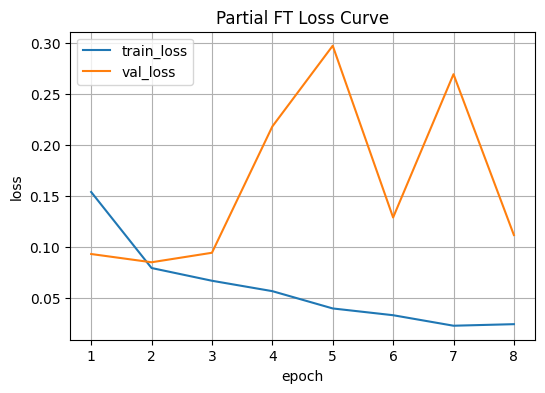

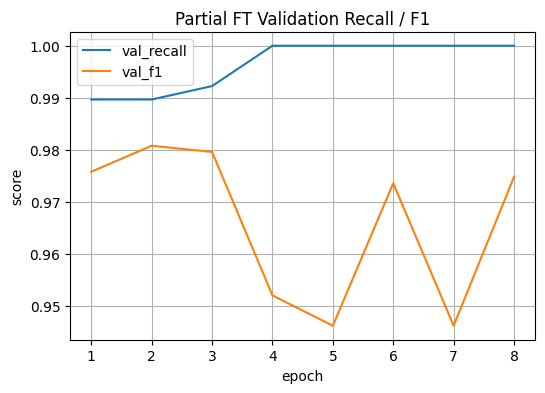

In [56]:
# [Code Cell] 7-10. Partial FT 학습 곡선 Plot

import matplotlib.pyplot as plt
epochs_axis = np.arange(1, len(history_partial["train_loss"]) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs_axis, history_partial["train_loss"], label="train_loss")
plt.plot(epochs_axis, history_partial["val_loss"], label="val_loss")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Partial FT Loss Curve")
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs_axis, history_partial["val_recall"], label="val_recall")
plt.plot(epochs_axis, history_partial["val_f1"], label="val_f1")
plt.xlabel("epoch"); plt.ylabel("score"); plt.title("Partial FT Validation Recall / F1")
plt.legend(); plt.grid(True); plt.show()

# 8. ResNet50 Full Fine-Tuning (Full FT)

이번 실험은 ResNet50의 **전체 파라미터를 학습(Full Fine-Tuning)** 합니다.

- Frozen / Partial FT 대비 표현력을 최대로 사용
- 단, 학습률이 너무 크면 불안정/과적합이 생길 수 있으므로 **작은 LR**로 시작합니다.
- Best 기준: **val Recall 최대**, 동률이면 **val F1 최대**

In [57]:
# [Code Cell] 8-1. Full FT 모델 생성

resnet_full = ResNet50Binary(pretrained=True).to(device)
print("Model created: ResNet50Binary (full fine-tuning)")

Model created: ResNet50Binary (full fine-tuning)


In [58]:
# [Code Cell] 8-2. Full FT: 전체 파라미터 unfreeze + trainable params 확인

for p in resnet_full.parameters():
    p.requires_grad = True

trainable = sum(p.numel() for p in resnet_full.parameters() if p.requires_grad)
total = sum(p.numel() for p in resnet_full.parameters())
print(f"Trainable params: {trainable:,} / Total params: {total:,}")

Trainable params: 23,510,081 / Total params: 23,510,081


In [59]:
# [Code Cell] 8-3. 학습 설정(Full FT)

RESNET_FULL_CFG = {
    "model_name": "ResNet50",
    "strategy": "full_ft",
    "epochs": 8,                    # 비교용으로 8~15 정도 추천
    "lr": CFG["lr_full"],           # 1e-4
    "weight_decay": CFG["weight_decay"],
    "use_pos_weight": False,
    "threshold": THRESHOLD,
    "save_dir": EXP_DIR / "checkpoints"
}
RESNET_FULL_CFG["save_dir"].mkdir(parents=True, exist_ok=True)

for k, v in RESNET_FULL_CFG.items():
    print(f"{k}: {v}")

model_name: ResNet50
strategy: full_ft
epochs: 8
lr: 1e-05
weight_decay: 0.0001
use_pos_weight: False
threshold: 0.5
save_dir: C:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\runs\mission6_resnet50_20260116_161455\checkpoints


In [60]:
# [Code Cell] 8-4. Optimizer / Criterion / Scheduler

criterion = make_bce_loss_with_optional_pos_weight(
    train_items_final,
    use_pos_weight=RESNET_FULL_CFG["use_pos_weight"]
)

optimizer = torch.optim.Adam(
    resnet_full.parameters(),
    lr=RESNET_FULL_CFG["lr"],
    weight_decay=RESNET_FULL_CFG["weight_decay"]
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=2
)

print("optimizer lr:", get_lr(optimizer))

optimizer lr: 1e-05


In [61]:
# [Code Cell] 8-5. 학습/검증 + Best 저장(Recall 우선, 동률이면 F1)

history_full = {
    "train_loss": [], "val_loss": [],
    "val_recall": [], "val_f1": [],
    "val_precision": [], "val_accuracy": [],
    "lr": []
}

best_recall = -1.0
best_f1 = -1.0
best_epoch = -1
best_path_full = RESNET_FULL_CFG["save_dir"] / "best_resnet50_full_ft.pt"

EPOCHS = RESNET_FULL_CFG["epochs"]
TH = RESNET_FULL_CFG["threshold"]

for epoch in range(1, EPOCHS + 1):
    train_loss, train_m = train_one_epoch(resnet_full, train_loader, optimizer, criterion, device, threshold=TH)
    val_loss, val_m     = evaluate(resnet_full, val_loader, criterion, device, threshold=TH)

    scheduler.step(val_loss)

    history_full["train_loss"].append(train_loss)
    history_full["val_loss"].append(val_loss)
    history_full["val_recall"].append(val_m["recall"])
    history_full["val_f1"].append(val_m["f1"])
    history_full["val_precision"].append(val_m["precision"])
    history_full["val_accuracy"].append(val_m["accuracy"])
    history_full["lr"].append(get_lr(optimizer))

    print(f"[FullFT Epoch {epoch:02d}/{EPOCHS}] train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | lr={get_lr(optimizer):.2e}")
    print("  train:", pretty_metrics(train_m))
    print("  val  :", pretty_metrics(val_m))

    # Best: Recall 최대, 동률이면 F1 최대
    is_best = False
    if val_m["recall"] > best_recall + 1e-12:
        is_best = True
    elif abs(val_m["recall"] - best_recall) <= 1e-12 and val_m["f1"] > best_f1 + 1e-12:
        is_best = True

    if is_best:
        best_recall = val_m["recall"]
        best_f1 = val_m["f1"]
        best_epoch = epoch

        info = {
            "train_loss": train_loss,
            "val_loss": val_loss,
            "val_metrics": val_m,
            "threshold": TH,
            "lr": get_lr(optimizer)
        }
        save_checkpoint(best_path_full, resnet_full, optimizer, epoch, best_key=best_recall, info=info)
        print(f"  -> Saved BEST: {best_path_full.name} (best_recall={best_recall:.4f}, best_f1={best_f1:.4f})")

[FullFT Epoch 01/8] train_loss=0.4676 | val_loss=0.2891 | lr=1.00e-05
  train: acc=0.8375 | prec=0.8560 | recall=0.9392 | f1=0.8957 | (tn,fp,fn,tp)=(656,551,212,3276)
  val  : acc=0.9155 | prec=0.9277 | recall=0.9612 | f1=0.9442 | (tn,fp,fn,tp)=(105,29,15,372)
  -> Saved BEST: best_resnet50_full_ft.pt (best_recall=0.9612, best_f1=0.9442)
[FullFT Epoch 02/8] train_loss=0.2255 | val_loss=0.1864 | lr=1.00e-05
  train: acc=0.9267 | prec=0.9557 | recall=0.9452 | f1=0.9504 | (tn,fp,fn,tp)=(1054,153,191,3297)
  val  : acc=0.9271 | prec=0.9246 | recall=0.9819 | f1=0.9524 | (tn,fp,fn,tp)=(103,31,7,380)
  -> Saved BEST: best_resnet50_full_ft.pt (best_recall=0.9819, best_f1=0.9524)
[FullFT Epoch 03/8] train_loss=0.1487 | val_loss=0.1174 | lr=1.00e-05
  train: acc=0.9502 | prec=0.9675 | recall=0.9653 | f1=0.9664 | (tn,fp,fn,tp)=(1094,113,121,3367)
  val  : acc=0.9559 | prec=0.9619 | recall=0.9793 | f1=0.9706 | (tn,fp,fn,tp)=(119,15,8,379)
[FullFT Epoch 04/8] train_loss=0.1213 | val_loss=0.1210 | l

In [62]:
# [Code Cell] 8-6. Best 로드 + Val 재평가(확인)

ckpt = torch.load(best_path_full, map_location=device, weights_only=False)
resnet_full.load_state_dict(ckpt["model_state"])

val_loss_best, val_m_best = evaluate(resnet_full, val_loader, criterion, device, threshold=TH)

print("Loaded best checkpoint:", best_path_full.name)
print("best epoch:", ckpt["epoch"])
print("val_loss(best):", f"{val_loss_best:.4f}")
print("val_metrics(best):", pretty_metrics(val_m_best))

Loaded best checkpoint: best_resnet50_full_ft.pt
best epoch: 5
val_loss(best): 0.1042
val_metrics(best): acc=0.9597 | prec=0.9530 | recall=0.9948 | f1=0.9735 | (tn,fp,fn,tp)=(115,19,2,385)


In [63]:
# [Code Cell] 8-7. 결과표(results_table)에 기록

import pandas as pd

if "results_table" not in globals():
    results_table = []

row = {
    "model": "ResNet50",
    "backbone": "resnet50",
    "strategy": "full_ft",
    "train_aug": TRAIN_AUG_NAME,
    "img_size": CFG["img_size"],
    "threshold": TH,
    "epochs": EPOCHS,
    "best_epoch": int(ckpt["epoch"]),
    "val_accuracy": float(val_m_best["accuracy"]),
    "val_precision": float(val_m_best["precision"]),
    "val_recall": float(val_m_best["recall"]),
    "val_f1": float(val_m_best["f1"]),
    "val_tn": int(val_m_best["tn"]),
    "val_fp": int(val_m_best["fp"]),
    "val_fn": int(val_m_best["fn"]),
    "val_tp": int(val_m_best["tp"]),
    "ckpt_path": str(best_path_full),
    "note": split_note
}
results_table.append(row)

df_results = pd.DataFrame(results_table)
df_results.sort_values(by=["val_recall", "val_f1"], ascending=False, inplace=True)
df_results.reset_index(drop=True, inplace=True)
df_results

,model,backbone,strategy,train_aug,img_size,threshold,epochs,best_epoch,val_accuracy,val_precision,val_recall,val_f1,val_tn,val_fp,val_fn,val_tp,ckpt_path,note
0,ResNet50,resnet50,partial_ft_layer4,aug1,224,0.5,8,8,0.961612,0.950860,1.000000,0.974811,114,20,0,387,C:\Users\amy\Desktop\sprint\sprint-ai07\미션\con...,Create new valid from train (ratio=0.1) due to...
1,CustomCNN3,custom,baseline_customcnn,aug1,224,0.5,8,1,0.760077,0.756863,0.997416,0.860647,10,124,1,386,C:\Users\amy\Desktop\sprint\sprint-ai07\미션\con...,Create new valid from train (ratio=0.1) due to...
2,ResNet50,resnet50,full_ft,aug1,224,0.5,8,5,0.959693,0.952970,0.994832,0.973451,115,19,2,385,C:\Users\amy\Desktop\sprint\sprint-ai07\미션\con...,Create new valid from train (ratio=0.1) due to...
3,ResNet50,resnet50,frozen,aug1,224,0.5,5,3,0.909789,0.914634,0.968992,0.941029,99,35,12,375,C:\Users\amy\Desktop\sprint\sprint-ai07\미션\con...,Create new valid from train (ratio=0.1) due to...


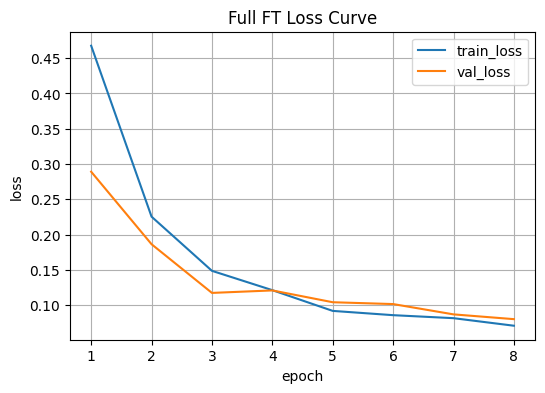

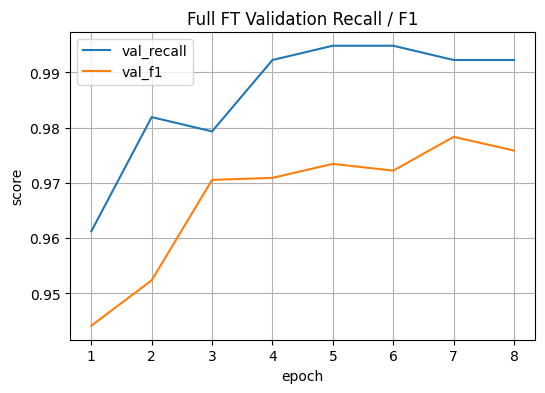

In [64]:
# [Code Cell] 8-8. Full FT 학습 곡선 Plot

import matplotlib.pyplot as plt
epochs_axis = np.arange(1, len(history_full["train_loss"]) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs_axis, history_full["train_loss"], label="train_loss")
plt.plot(epochs_axis, history_full["val_loss"], label="val_loss")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Full FT Loss Curve")
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs_axis, history_full["val_recall"], label="val_recall")
plt.plot(epochs_axis, history_full["val_f1"], label="val_f1")
plt.xlabel("epoch"); plt.ylabel("score"); plt.title("Full FT Validation Recall / F1")
plt.legend(); plt.grid(True); plt.show()


# 9. Final Test Evaluation + Model Comparison + Conclusion

이 섹션에서는 앞에서 학습한 모델들(Custom CNN / ResNet50 Frozen / ResNet50 Partial FT / ResNet50 Full FT)을
**동일한 기준(Threshold=0.5)**으로 Test set에서 평가하고 비교합니다.

- 의료 진단 관점에서 **False Negative(FN, 미탐지)** 를 최소화하는 것이 중요하므로 **Recall 중심**으로 해석합니다.
- 다만 Recall만 높이고 FP가 과도하게 증가하면 실제 진단에서 부담이 커질 수 있어, **F1-score도 함께 확인**합니다.
- 마지막으로 최종 제출 모델을 선택하고, 향후 개선 방향(증강 정책 확장 등)을 정리합니다.

In [65]:
# [Code Cell] 9-1. 평가에 사용할 모델 체크포인트 경로 정리

# 앞 섹션에서 저장한 best 경로들을 사용 (이미 변수로 존재해야 함)
model_ckpts = {
    "CustomCNN3": {
        "path": best_path,                  # 5번 best
        "type": "custom"
    },
    "ResNet50_frozen": {
        "path": best_path_frozen,           # 6번 best
        "type": "resnet"
    },
    "ResNet50_partial": {
        "path": best_path_partial,          # 7번 best
        "type": "resnet"
    },
    "ResNet50_full": {
        "path": best_path_full,             # 8번 best
        "type": "resnet"
    },
}
for k, v in model_ckpts.items():
    print(k, "->", v["path"])

CustomCNN3 -> C:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\runs\mission6_resnet50_20260116_161455\checkpoints\best_custom_cnn.pt
ResNet50_frozen -> C:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\runs\mission6_resnet50_20260116_161455\checkpoints\best_resnet50_frozen.pt
ResNet50_partial -> C:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\runs\mission6_resnet50_20260116_161455\checkpoints\best_resnet50_partial_ft.pt
ResNet50_full -> C:\Users\amy\Desktop\sprint\sprint-ai07\미션\content\runs\mission6_resnet50_20260116_161455\checkpoints\best_resnet50_full_ft.pt


In [66]:
# [Code Cell] 9-2. 모델 로더 함수(체크포인트 로드)

def load_model_from_ckpt(model_key: str, ckpt_path: Path, device):
    """
    model_key에 따라 동일한 아키텍처를 생성한 뒤 state_dict 로드.
    PyTorch 2.6 호환: weights_only=False
    """
    entry = model_ckpts[model_key]
    mtype = entry["type"]

    if mtype == "custom":
        model = CustomCNN3().to(device)
    elif mtype == "resnet":
        model = ResNet50Binary(pretrained=False).to(device)  # 가중치는 ckpt에서 로드하므로 pretrained=False
    else:
        raise ValueError("Unknown model type")

    ckpt = torch.load(ckpt_path, map_location=device, weights_only=False)
    model.load_state_dict(ckpt["model_state"])
    model.eval()
    return model, ckpt

In [67]:
# [Code Cell] 9-3. (Baseline) Test에서 '항상 폐렴' / '항상 정상' 기준도 같이 확인(참고용)

def eval_constant_baseline(loader, device, pred_label: int):
    """
    pred_label: 0(NORMAL) 또는 1(PNEUMONIA)
    """
    meter = MetricsAccumulator(pos_label=POS_LABEL)
    for batch in loader:
        y = batch["label"].to(device).long()
        pred = torch.full_like(y, fill_value=pred_label)
        meter.update(y_true_batch=y, y_pred_batch=pred)
    return meter.compute()

test_all_pos = eval_constant_baseline(test_loader, device, pred_label=1)
test_all_neg = eval_constant_baseline(test_loader, device, pred_label=0)

print("[Test Baseline] Always PNEUMONIA:", pretty_metrics(test_all_pos))
print("[Test Baseline] Always NORMAL  :", pretty_metrics(test_all_neg))

[Test Baseline] Always PNEUMONIA: acc=0.6250 | prec=0.6250 | recall=1.0000 | f1=0.7692 | (tn,fp,fn,tp)=(0,234,0,390)
[Test Baseline] Always NORMAL  : acc=0.3750 | prec=0.0000 | recall=0.0000 | f1=0.0000 | (tn,fp,fn,tp)=(234,0,390,0)


In [68]:
# [Code Cell] 9-4. 각 모델 Test 평가(Recall/F1/Confusion) + 결과표 업데이트

TH = THRESHOLD

test_rows = []
for model_key, entry in model_ckpts.items():
    model, ckpt = load_model_from_ckpt(model_key, entry["path"], device=device)

    # test set 평가
    test_loss, test_m = evaluate(model, test_loader, criterion, device, threshold=TH)

    row = {
        "model_key": model_key,
        "ckpt": str(entry["path"]),
        "threshold": TH,
        "test_loss": float(test_loss),
        "test_accuracy": float(test_m["accuracy"]),
        "test_precision": float(test_m["precision"]),
        "test_recall": float(test_m["recall"]),
        "test_f1": float(test_m["f1"]),
        "test_tn": int(test_m["tn"]),
        "test_fp": int(test_m["fp"]),
        "test_fn": int(test_m["fn"]),
        "test_tp": int(test_m["tp"]),
        "best_epoch": int(ckpt.get("epoch", -1))
    }
    test_rows.append(row)

    print(f"[TEST {model_key}] loss={test_loss:.4f} | {pretty_metrics(test_m)}")

import pandas as pd
df_test = pd.DataFrame(test_rows)
df_test.sort_values(by=["test_recall", "test_f1"], ascending=False, inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_test

[TEST CustomCNN3] loss=0.9598 | acc=0.6250 | prec=0.6254 | recall=0.9974 | f1=0.7688 | (tn,fp,fn,tp)=(1,233,1,389)
[TEST ResNet50_frozen] loss=0.5567 | acc=0.7644 | prec=0.7323 | recall=0.9821 | f1=0.8390 | (tn,fp,fn,tp)=(94,140,7,383)
[TEST ResNet50_partial] loss=1.1849 | acc=0.7917 | prec=0.7500 | recall=1.0000 | f1=0.8571 | (tn,fp,fn,tp)=(104,130,0,390)
[TEST ResNet50_full] loss=0.5989 | acc=0.7949 | prec=0.7549 | recall=0.9949 | f1=0.8584 | (tn,fp,fn,tp)=(108,126,2,388)


,model_key,ckpt,threshold,test_loss,test_accuracy,test_precision,test_recall,test_f1,test_tn,test_fp,test_fn,test_tp,best_epoch
0,ResNet50_partial,C:\Users\amy\Desktop\sprint\sprint-ai07\미션\con...,0.5,1.184917,0.791667,0.750000,1.000000,0.857143,104,130,0,390,8
1,CustomCNN3,C:\Users\amy\Desktop\sprint\sprint-ai07\미션\con...,0.5,0.959818,0.625000,0.625402,0.997436,0.768775,1,233,1,389,1
2,ResNet50_full,C:\Users\amy\Desktop\sprint\sprint-ai07\미션\con...,0.5,0.598919,0.794872,0.754864,0.994872,0.858407,108,126,2,388,5
3,ResNet50_frozen,C:\Users\amy\Desktop\sprint\sprint-ai07\미션\con...,0.5,0.556698,0.764423,0.732314,0.982051,0.838992,94,140,7,383,3


In [69]:
# [Code Cell] 9-5. valid + test 결과 합쳐서 최종 비교표 만들기

import pandas as pd

df_valid = pd.DataFrame(results_table).copy()

# strategy 기준으로 키 맞추기(우리가 저장한 이름과 df_test model_key 매핑)
map_valid_to_key = {
    "baseline_customcnn": "CustomCNN3",
    "frozen": "ResNet50_frozen",
    "partial_ft_layer4": "ResNet50_partial",
    "full_ft": "ResNet50_full",
}

df_valid["model_key"] = df_valid["strategy"].map(map_valid_to_key)

df_merged = df_valid.merge(df_test, on="model_key", how="left", suffixes=("_val", "_test"))
cols = [
    "model_key", "strategy",
    "val_recall", "val_f1", "val_precision", "val_accuracy",
    "test_recall", "test_f1", "test_precision", "test_accuracy",
    "ckpt_path"
]
df_merged = df_merged[cols].sort_values(by=["test_recall", "test_f1"], ascending=False).reset_index(drop=True)
df_merged

,model_key,strategy,val_recall,val_f1,val_precision,val_accuracy,test_recall,test_f1,test_precision,test_accuracy,ckpt_path
0,ResNet50_partial,partial_ft_layer4,1.000000,0.974811,0.950860,0.961612,1.000000,0.857143,0.750000,0.791667,C:\Users\amy\Desktop\sprint\sprint-ai07\미션\con...
1,CustomCNN3,baseline_customcnn,0.997416,0.860647,0.756863,0.760077,0.997436,0.768775,0.625402,0.625000,C:\Users\amy\Desktop\sprint\sprint-ai07\미션\con...
2,ResNet50_full,full_ft,0.994832,0.973451,0.952970,0.959693,0.994872,0.858407,0.754864,0.794872,C:\Users\amy\Desktop\sprint\sprint-ai07\미션\con...
3,ResNet50_frozen,frozen,0.968992,0.941029,0.914634,0.909789,0.982051,0.838992,0.732314,0.764423,C:\Users\amy\Desktop\sprint\sprint-ai07\미션\con...


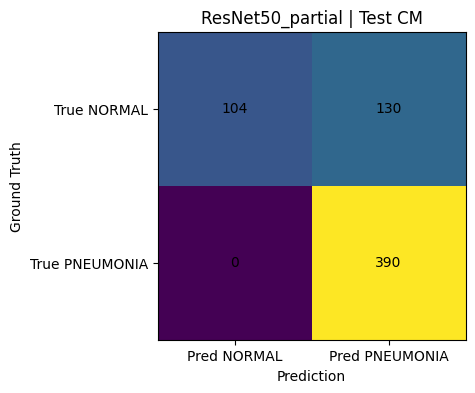

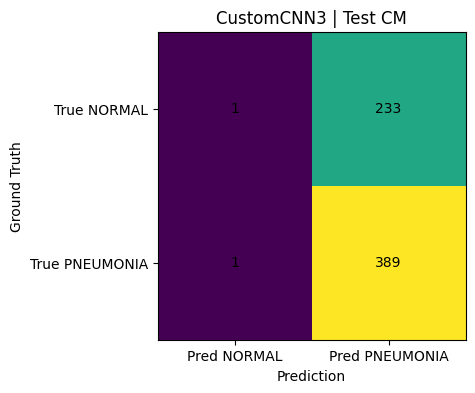

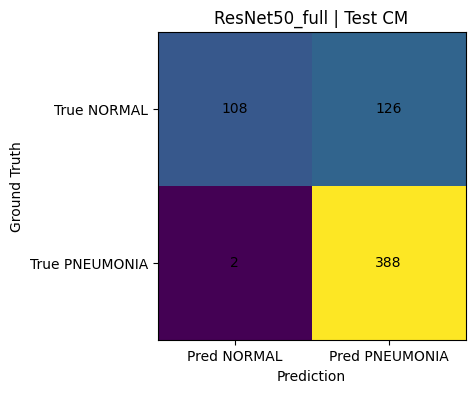

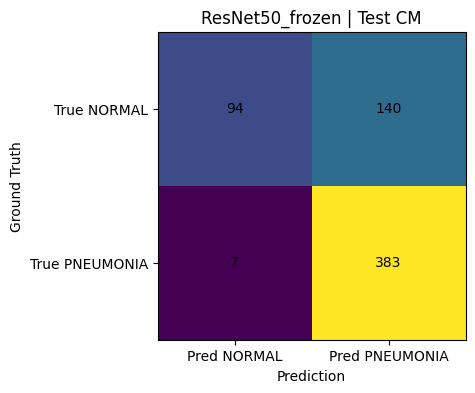

In [71]:
# [Code Cell] 9-6. Confusion Matrix 시각화(모델별)

import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_from_row(row, title="Confusion Matrix"):
    tn, fp, fn, tp = row["test_tn"], row["test_fp"], row["test_fn"], row["test_tp"]
    cm = np.array([[tn, fp],
                   [fn, tp]])

    plt.figure(figsize=(4,4))
    plt.imshow(cm)
    plt.title(title)
    plt.xticks([0,1], ["Pred NORMAL", "Pred PNEUMONIA"])
    plt.yticks([0,1], ["True NORMAL", "True PNEUMONIA"])

    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(cm[i, j]), ha="center", va="center")

    plt.xlabel("Prediction")
    plt.ylabel("Ground Truth")
    plt.grid(False)
    plt.show()

# df_test 상위 2개만 시각화(원하면 숫자 바꿔도 됨)
for i in range(min(4, len(df_test))):
    r = df_test.iloc[i]
    plot_confusion_from_row(r, title=f"{r['model_key']} | Test CM")

## 최종 해석 및 제출 모델 선택

* 본 과제는 의료 진단(폐렴 분류) 문제로, **False Negative(FN: 폐렴인데 정상으로 분류)** 가 환자 안전 측면에서 가장 치명적입니다.
  따라서 모델 선택 기준을 **Recall 최우선**으로 두고, 동시에 “무조건 폐렴으로 예측” 같은 편향을 피하기 위해 **F1-score를 보조 지표**로 함께 확인했습니다.

* 테스트 셋의 클래스 분포를 고려하면, 단순 기준선(Always PNEUMONIA)도 Recall 1.0을 달성할 수 있습니다.
  그러나 이는 정상 환자를 과도하게 폐렴으로 오진(FP 증가)하는 방식이므로, **Recall을 유지하면서도 Precision/F1을 개선하는지**가 실제 모델 성능의 핵심입니다.

* 실험 결과, **ResNet50 기반 전이학습 모델들이 Custom CNN 대비 전반적으로 우수**했습니다.
  특히 **Partial Fine-Tuning과 Full Fine-Tuning**은 Recall이 매우 높게 유지되면서도, 기준선/Custom CNN 대비 정상 오진(FP)을 줄여 **F1 및 정확도 측면에서도 개선**을 보였습니다.

* 최종 제출 모델은 다음 원칙으로 선택합니다.

  1. **Test Recall이 가장 높은 모델**을 1순위로 선택
  2. Recall이 동률(또는 사실상 동급)일 경우, **Test F1이 높은 모델**을 선택
  3. 의료 관점에서 **FN 최소화가 최우선**이므로, Recall이 완벽(또는 거의 완벽)한 후보군 내에서 F1이 가장 높은 모델을 최종 모델로 결정합니다.
     → 본 실험 결과에서는 **ResNet50_partial이 Test Recall 1.0(FN=0)** 을 달성했고, F1 또한 높은 수준을 보여 **최종 제출 모델로 채택하기에 가장 타당**합니다.

---

## 향후 개선 방향

* 이번 실험에서는 회전/이동/크롭 등 **on-the-fly 데이터 증강**을 적용해 일반화 성능 향상을 시도했습니다.
  향후에는 픽셀 수준 변환을 포함해 **학습 데이터 분포를 더 넓히는 증강 정책 탐색**을 진행할 수 있습니다.
  예) **밝기/대비(ColorJitter), 약한 블러/노이즈, gamma 조정**, 증강 강도 단계화(Aug1/Aug2/Aug3), 클래스별 증강 강도 차등 적용 등

* 또한 현재는 분류 임계값을 **0.5로 고정**했지만, 의료 문제에서는 목적이 “정확도 최대”가 아니라 “FN 최소화(Recall 최대)”에 가까우므로,
  **Validation에서 Recall을 최대한 유지하는 범위에서 threshold를 조정하여 FP를 줄이는 방식**이 효과적일 수 있습니다.
  즉, 모델 자체를 바꾸기보다 **결정 기준을 목적 함수에 맞게 조정**함으로써 실사용 관점의 성능을 개선할 여지가 있습니다.

* 마지막으로, 클래스 불균형/비용 민감도를 반영하기 위해 **손실 함수에 가중치를 부여**하거나(Weighted CE), **Focal Loss** 등 FN에 더 민감한 학습 전략을 도입하는 것도 고려할 수 있습니다.
  이는 “Recall을 유지하면서 정상 오진(FP)을 완화”하는 방향의 추가 개선안이 될 수 있습니다.

LR/스케줄/threshold/손실 가중치 같은 ‘미세 조정’으로 목표 지표(recall) 맞추기는 어떻게 할 수 있어? 해당 코드셀에서 조금만 바꾸면 되는 거지? 바꿔보고 에폭 다 돌아가면 다시 결과표 코드 셀 실행해서 결과 또 비교해보고 이런 식으로?